In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from functools import reduce

In [2]:
# Values for data cleaning / imputation
md_threshold = 80
impute_n = 3

### OECD Datasets Preparation

In [3]:
# Load all

# OECD HCQI // Healthcare Quality Indicators
hcqi = pd.read_csv("OECD/HEALTH_HCQI_22092023205825625.csv")

# OECD LVNG // Non-Medical Determinants of Health
lvng = pd.read_csv("OECD/HEALTH_LVNG_25092023023230295.csv")

# OECD STAT // Health Statistics
stat = pd.read_csv("OECD/HEALTH_STAT_25092023023520080.csv")

# OECD PROT // Social Protection
prot = pd.read_csv("OECD/HEALTH_PROT_22092023205920251.csv")

# OECD DEMR // Demographics
demr = pd.read_csv("OECD/HEALTH_DEMR_25092023023656863.csv")

# OECD ECOR // Economic References
ecor = pd.read_csv("OECD/HEALTH_ECOR_28092023052908229.csv")

oecd_datasets = [hcqi, lvng, stat, prot, demr, ecor]

In [4]:
# Preliminary Cleaning

def clean_oecd_df(df):
    """Removes redundant or unneeded columns from OECD datasets"""

    df.drop(['Flag Codes', 'Flags'], axis=1, inplace=True)
    if 'YEA' in df.columns:
        df.drop(['YEA'], axis=1, inplace=True)
    else:
        df.drop(['PER'], axis=1, inplace=True)

    return df

oecd_datasets = [clean_oecd_df(x) for x in oecd_datasets]

# Renaming columns in HCQI to match other datasets
hcqi.rename(columns={'Indicator': 'Variable', 'IND': 'VAR', 'Periods': 'Year'}, inplace=True)

hcqi.head()

,COU,Country,Year,VAR,Variable,GEN,Gender,AGE,Age Group,VAL,Value,Value.1
0,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,AS_STD_RATE_MPOP,Age-sex standardised rate per 100 000 population,40.4
1,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,LOW_CI,Lower confidence interval,39.1
2,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,UP_CI,Upper confidence interval,41.8
3,AUS,Australia,2012,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,AS_STD_RATE_MPOP,Age-sex standardised rate per 100 000 population,36.8
4,AUS,Australia,2012,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,LOW_CI,Lower confidence interval,35.5


In [5]:
# Reformatting HCQI data for merging

# Rename indicators with more info and then drop unnecessary columns
hcqi['VAR'] = hcqi['VAR'] + '_' + hcqi['GEN'] + '_' + hcqi['AGE'] + '_' + hcqi['VAL']
hcqi.drop(['Country', 'Variable', 'GEN', 'Gender', 'AGE', 'Age Group', 'VAL', 'Value'], axis=1, inplace=True)
hcqi.rename(columns={'Value.1': 'Value'}, inplace=True)

hcqi.head()

,COU,Year,VAR,Value
0,AUS,2011,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,40.4
1,AUS,2011,ADMRASTH_M_TOTAL_15_LOW_CI,39.1
2,AUS,2011,ADMRASTH_M_TOTAL_15_UP_CI,41.8
3,AUS,2012,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,36.8
4,AUS,2012,ADMRASTH_M_TOTAL_15_LOW_CI,35.5


In [6]:
# Merging of OECD datasets

merged_df = pd.concat(oecd_datasets[:])
merged_df = merged_df[['VAR', 'COU', 'Year', 'Value']]
merged_df.rename(columns={'COU': 'Country'}, inplace=True)

merged_df.head()

,VAR,Country,Year,Value
0,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,AUS,2011,40.4
1,ADMRASTH_M_TOTAL_15_LOW_CI,AUS,2011,39.1
2,ADMRASTH_M_TOTAL_15_UP_CI,AUS,2011,41.8
3,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,AUS,2012,36.8
4,ADMRASTH_M_TOTAL_15_LOW_CI,AUS,2012,35.5


In [7]:
# Transforming data into wide format

merged_df = pd.pivot_table(merged_df, index=['Country', 'Year'], columns='VAR', values='Value').reset_index().rename_axis(None, axis=1)

merged_df.head()

,Country,Year,ACOLALCT,ADMDEALL_F_TOTAL_CRUDE_RATE_MORT,ADMDEALL_M_TOTAL_CRUDE_RATE_MORT,ADMDEALL_T_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_F_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_M_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_T_TOTAL_CRUDE_RATE_MORT,ADMDECAN_F_TOTAL_CRUDE_RATE_MORT,...,SRHSTGHB,SRHSTGHC,SRHSTGHD,SRHSTGHE,STRUPP80,STRUSFPL,TOBATBCT,TPRIBASI,VAPEVAPA,VAPEVAPY
0,ARG,2010,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,501.375,2074.125,28.433333,NaN,NaN,NaN
1,ARG,2011,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,513.025,2116.825,NaN,NaN,NaN,NaN
2,ARG,2012,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,524.475,2163.300,NaN,NaN,NaN,NaN
3,ARG,2013,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,535.825,2213.025,NaN,NaN,NaN,NaN
4,ARG,2014,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,547.200,2265.425,NaN,NaN,NaN,NaN


In [8]:
# Output raw fully merged dataset

merged_df.to_csv('OECD/HEALTH_MERGED.csv', index=False)

### Investigating Missing Data

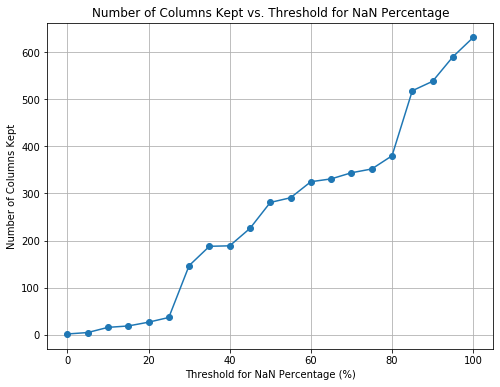

In [9]:
# Drop columns where the number of NaN's is greater than a given threshold % 
# First determine what that threshold should be

# Range of thresholds to test
thresholds = range(0, 101, 5)  # Vary from 0% to 100% in increments of 5%

# Calculate the percentage of NaNs per column
nan_percentage = (merged_df.isna().mean() * 100).round(2)

# Initialize lists to store results
threshold_values = []
kept_columns = []

# Calculate the number of columns kept for each threshold
for threshold in thresholds:
    columns_to_drop = nan_percentage > threshold
    kept_columns_count = sum(~columns_to_drop)  # Count columns that are not dropped
    threshold_values.append(threshold)
    kept_columns.append(kept_columns_count)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(threshold_values, kept_columns, marker='o', linestyle='-')
plt.title('Number of Columns Kept vs. Threshold for NaN Percentage')
plt.xlabel('Threshold for NaN Percentage (%)')
plt.ylabel('Number of Columns Kept')
plt.grid(True)
plt.show()

In [10]:
# Missing data percentage of Maternal Mortality indicator 
print((merged_df['MATIMATM'].isna().mean() * 100).round(2))

31.35


In [11]:
# Create a boolean mask for columns with more than the threshold percentage of NaNs
columns_to_drop = nan_percentage > md_threshold

# Drop the columns with more than the threshold percentage of NaNs
df_cleaned = merged_df.drop(columns=nan_percentage[columns_to_drop].index)
df_cleaned = df_cleaned.dropna(subset=['MATIMATM']) # Drop rows without MM indicator
df_cleaned

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,SRHSMGHE,SRHSTGHA,SRHSTGHB,SRHSTGHC,SRHSTGHD,SRHSTGHE,STRUPP80,STRUSFPL,TOBATBCT,TPRIBASI
13,AUS,2010,10.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,412.725,1496.725,138.5625,100.0
14,AUS,2011,10.2,97.9,95.9,99.9,40.4,39.1,41.8,70.6,...,85.4,90.9,90.5,83.4,72.1,85.4,424.750,1547.400,971.7000,100.0
15,AUS,2012,10.0,91.1,89.2,93.1,36.8,35.5,38.0,65.3,...,NaN,NaN,NaN,NaN,NaN,NaN,433.750,1610.475,964.7000,100.0
16,AUS,2013,9.9,84.9,83.1,86.8,34.8,33.5,36.0,61.1,...,NaN,NaN,NaN,NaN,NaN,NaN,442.550,1668.775,125.3125,100.0
17,AUS,2014,9.7,93.3,91.4,95.2,35.2,34.0,36.5,65.7,...,85.4,91.0,90.5,83.6,72.8,85.2,451.500,1724.725,830.8000,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,TUR,2020,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.7,93.2,83.2,55.0,22.7,69.4,751.850,3777.650,1182.4000,98.5
629,TUR,2021,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72.3,91.4,80.8,53.4,25.6,67.8,764.350,3979.175,1252.0000,98.8
639,USA,2018,8.9,53.0,52.6,53.4,20.5,20.2,20.7,37.5,...,88.1,96.1,93.1,84.7,77.8,87.5,6330.675,26181.300,140.0875,90.6
640,USA,2019,9.0,52.3,51.9,52.7,20.9,20.6,21.1,37.3,...,85.1,93.5,90.9,81.4,74.9,84.7,6458.275,27022.475,133.1250,89.7


In [12]:
# Encode the country

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
df_cleaned["Country"] = country_encoder.fit_transform(df_cleaned["Country"])

df_cleaned.head()

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,SRHSMGHE,SRHSTGHA,SRHSTGHB,SRHSTGHC,SRHSTGHD,SRHSTGHE,STRUPP80,STRUSFPL,TOBATBCT,TPRIBASI
13,0,2010,10.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,412.725,1496.725,138.5625,100.0
14,0,2011,10.2,97.9,95.9,99.9,40.4,39.1,41.8,70.6,...,85.4,90.9,90.5,83.4,72.1,85.4,424.750,1547.400,971.7000,100.0
15,0,2012,10.0,91.1,89.2,93.1,36.8,35.5,38.0,65.3,...,NaN,NaN,NaN,NaN,NaN,NaN,433.750,1610.475,964.7000,100.0
16,0,2013,9.9,84.9,83.1,86.8,34.8,33.5,36.0,61.1,...,NaN,NaN,NaN,NaN,NaN,NaN,442.550,1668.775,125.3125,100.0
17,0,2014,9.7,93.3,91.4,95.2,35.2,34.0,36.5,65.7,...,85.4,91.0,90.5,83.6,72.8,85.2,451.500,1724.725,830.8000,100.0


In [13]:
# Scale data
scaler = MinMaxScaler()

# Define the columns to include in scaling and imputation
columns_to_scale = df_cleaned.columns[2:]  # Exclude the first two columns
columns_to_exclude = ['MATIMATM']  # Add the maternal mortality column to exclude

# Separate the columns to scale and exclude
columns_to_scale = [col for col in columns_to_scale if col not in columns_to_exclude]

X = df_cleaned[columns_to_scale]
X = scaler.fit_transform(X)

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors = impute_n)
imputed_data = knn_imputer.fit_transform(X)
df_cleaned[columns_to_scale] = imputed_data

imputed_df = df_cleaned.copy()
imputed_df

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,SRHSMGHE,SRHSTGHA,SRHSTGHB,SRHSTGHC,SRHSTGHD,SRHSTGHE,STRUPP80,STRUSFPL,TOBATBCT,TPRIBASI
13,0,2010,0.681481,0.438622,0.447901,0.429774,0.356844,0.374339,0.345149,0.415388,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.063018,0.054214,0.062535,0.975265
14,0,2011,0.666667,0.470645,0.480000,0.461392,0.386473,0.404762,0.375000,0.446931,...,0.901338,0.853383,0.913732,0.895735,0.808411,0.902280,0.064881,0.056077,0.452228,0.975265
15,0,2012,0.651852,0.437652,0.446914,0.428980,0.351691,0.369048,0.339552,0.413043,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.066276,0.058395,0.448954,0.975265
16,0,2013,0.644444,0.407569,0.416790,0.398951,0.332367,0.349206,0.320896,0.386189,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.067640,0.060539,0.056338,0.975265
17,0,2014,0.629630,0.448326,0.457778,0.438990,0.336232,0.354167,0.325560,0.415601,...,0.901338,0.855263,0.913732,0.898894,0.816589,0.899023,0.069027,0.062596,0.386323,0.975265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,38,2020,0.000000,0.712276,0.727737,0.697013,0.326570,0.346561,0.313122,0.615303,...,0.705686,0.896617,0.785211,0.447077,0.231308,0.641694,0.115578,0.138067,0.550781,0.922261
629,38,2021,0.014815,0.537441,0.551440,0.523832,0.281481,0.301918,0.268346,0.472933,...,0.682274,0.862782,0.742958,0.421801,0.265187,0.615635,0.117515,0.145476,0.583336,0.932862
639,39,2018,0.570370,0.252790,0.266173,0.239752,0.194203,0.217262,0.178172,0.235294,...,0.946488,0.951128,0.959507,0.916272,0.875000,0.936482,0.980224,0.961695,0.063248,0.643110
640,39,2019,0.577778,0.249393,0.262716,0.236416,0.198068,0.221230,0.181903,0.234015,...,0.896321,0.902256,0.920775,0.864139,0.841121,0.890879,1.000000,0.992619,0.059992,0.611307


In [14]:
# Cast Year and Country to an integer data type
imputed_df['Year'] = imputed_df['Year'].astype(int)
imputed_df['Country'] = imputed_df['Country'].astype(int)

# Decode the 'Country' column
imputed_df['Country'] = country_encoder.inverse_transform(imputed_df['Country'])

imputed_df.head()


,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,SRHSMGHE,SRHSTGHA,SRHSTGHB,SRHSTGHC,SRHSTGHD,SRHSTGHE,STRUPP80,STRUSFPL,TOBATBCT,TPRIBASI
13,AUS,2010,0.681481,0.438622,0.447901,0.429774,0.356844,0.374339,0.345149,0.415388,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.063018,0.054214,0.062535,0.975265
14,AUS,2011,0.666667,0.470645,0.480000,0.461392,0.386473,0.404762,0.375000,0.446931,...,0.901338,0.853383,0.913732,0.895735,0.808411,0.902280,0.064881,0.056077,0.452228,0.975265
15,AUS,2012,0.651852,0.437652,0.446914,0.428980,0.351691,0.369048,0.339552,0.413043,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.066276,0.058395,0.448954,0.975265
16,AUS,2013,0.644444,0.407569,0.416790,0.398951,0.332367,0.349206,0.320896,0.386189,...,0.897993,0.860276,0.913146,0.892575,0.818536,0.900109,0.067640,0.060539,0.056338,0.975265
17,AUS,2014,0.629630,0.448326,0.457778,0.438990,0.336232,0.354167,0.325560,0.415601,...,0.901338,0.855263,0.913732,0.898894,0.816589,0.899023,0.069027,0.062596,0.386323,0.975265


In [15]:
# Output cleaned OECD dataset

filename = 'OECD/Cleaned/HEALTH_MERGED_Threshold_' + str(md_threshold) + '_n' + str(impute_n) + '.csv'
imputed_df.to_csv(filename, index=False)